In [266]:
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
import geopandas as gpd
from shapely.ops import nearest_points
import pyproj

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

import seaborn as sns

cwd =os.getcwd()

In [95]:
background_data = pd.read_csv('final_data2019.csv').drop(columns='geometry')
geodata = gpd.read_file(cwd+'\scrape_geodata\geodata\dagi_10m_nohist_l1.afstemningsomraade\\afstemningsomraade.shp', driver = 'ESRI Shapefile')
geodata = geodata[['objectid', 'geometry']]
geodata['objectid'] = geodata['objectid'].astype(int)
final_gdf = geodata.merge(background_data, on='objectid', how='right')

In [215]:
final_gdf['left_share_norm']=final_gdf['left_share']/(final_gdf['left_share']+final_gdf['right_share'])
final_gdf['pop_density_log']=np.log(final_gdf['pop_density'])
final_gdf['disindk_log']=np.log(final_gdf['disindk'])

In [217]:
X = final_gdf[['karakter', 'salgspris', 'disindk', 'kriminelitet', 'lavindk',
               'langledig', 'skilsmisser', 'andel_indv', 'pop_density', 'pop_density_log', 'disindk_log']]
y = final_gdf['left_share_norm']

# splitting into development (2/3) and test data (1/3)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

# splitting development into train (1/3) and validation (1/3)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

In [281]:
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=True), 
                           StandardScaler(),
                            LinearRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_val)
mse(y_pred, y_val)

0.004166719192746821

## Lasso:

In [222]:
perform = []
lambdas = np.logspace(-6, 2, 33)
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.8f' % optimal.values[0])



Optimal lambda: 0.0001
Validation MSE: 0.00390363


<AxesSubplot:xlabel='x_axis', ylabel='0'>

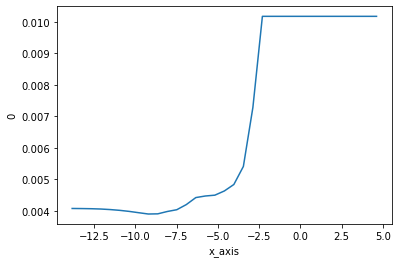

In [223]:
plot_df = pd.DataFrame(hyperparam_perform).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [221]:
# list(zip(pipe_lasso.steps[2][1].coef_, pipe_lasso.steps[0][1].get_feature_names(X.columns)))

## Ridge:

In [285]:
perform = []
lambdas = np.logspace(-6, 6, 33)
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(include_bias=True), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_pred, y_val))
    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.8f' % optimal.values[0])

Optimal lambda: 13.33521432163324
Validation MSE: 0.00413596


In [233]:
errors = pipe_ridge.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
# error_gdf.plot(column='left_share_norm_y', legend=True)

ValueError: X shape does not match training shape

<AxesSubplot:xlabel='x_axis', ylabel='0'>

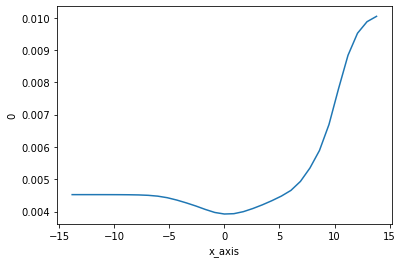

In [167]:
plot_df = pd.DataFrame(hyperparam_perform).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [226]:
# list(zip(pipe_ridge.steps[2][1].coef_, pipe_ridge.steps[0][1].get_feature_names(X.columns)))

## Lasso - crossvalidation

In [260]:
kfolds = KFold(n_splits=10)
# kfolds = LeaveOneOut()

folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mselassoCV = []
lambdas = np.logspace(-5, -4, 100)
for lambda_ in lambdas:    
    # inner loop: folds
    mselassoCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_lassoCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Lasso(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_lassoCV.fit(X_train, y_train)        
        mselassoCV_.append(mse(pipe_lassoCV.predict(X_val), y_val))    
        
    # store result    
    mselassoCV.append(mselassoCV_) 
    
# convert to DataFrame
lambdalassoCV = pd.DataFrame(mselassoCV, index=lambdas)

0.000066    0.003776
dtype: float64


<AxesSubplot:xlabel='x_axis', ylabel='0'>

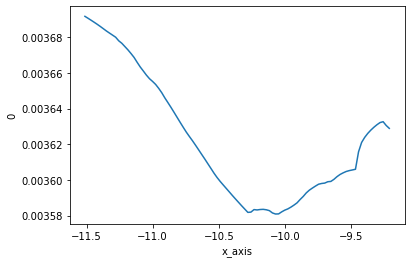

In [261]:
print(lambdalassoCV.mean(axis=1).nsmallest(1))
plot_df = pd.DataFrame(lambdalassoCV).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

In [243]:
# errors = pipe_lassoCV.predict(X_test)-y_test
# error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
# error_gdf.plot(column='left_share_norm_y', legend=True)
# error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

<AxesSubplot:xlabel='left_share_norm_y'>

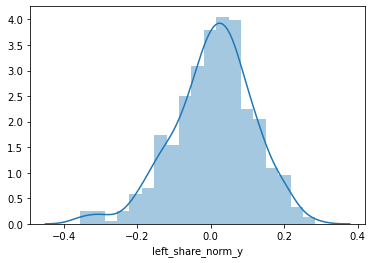

In [197]:
sns.distplot(error_gdf['left_share_norm_y'])

## Ridge - crossvalidation

In [246]:
kfolds = KFold(n_splits=10)
# kfolds = LeaveOneOut()

folds = list(kfolds.split(X_dev, y_dev))
# outer loop: lambdas
mseridgeCV = []
lambdas = np.logspace(-4, 4, 100)
for lambda_ in lambdas:    
    # inner loop: folds
    mseridgeCV_ = []    
    for train_idx, val_idx in folds:        
        # train model and compute MSE on test fold
        pipe_ridgeCV = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),
                                     StandardScaler(),
                                     Ridge(alpha=lambda_, random_state=1))            
        X_train, y_train = X_dev.values[train_idx], y_dev.values[train_idx]
        X_val, y_val = X_dev.values[val_idx], y_dev.values[val_idx] 
        pipe_ridgeCV.fit(X_train, y_train)        
        mseridgeCV_.append(mse(pipe_ridgeCV.predict(X_val), y_val))    
        
    # store result    
    mseridgeCV.append(mseridgeCV_) 
    
# convert to DataFrame
lambdaridgeCV = pd.DataFrame(mseridgeCV, index=lambdas)

1.592283    0.003734
dtype: float64


<AxesSubplot:xlabel='x_axis', ylabel='0'>

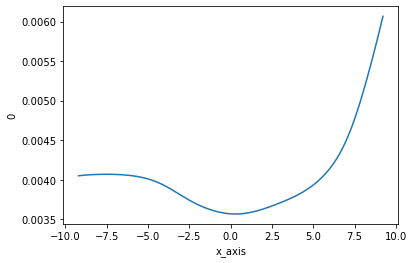

In [255]:
print(lambdaridgeCV.mean(axis=1).nsmallest(1))
plot_df = pd.DataFrame(lambdaridgeCV).reset_index()
plot_df['index'] = np.log(plot_df['index'])
plot_df['x_axis'] = plot_df['index']
sns.lineplot(data=plot_df, x='x_axis', y=0)

<AxesSubplot:>

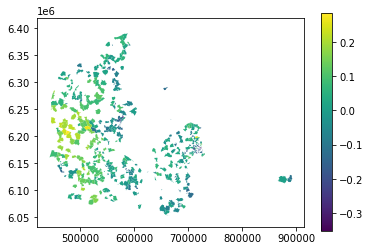

In [174]:
errors = pipe_ridgeCV.predict(X_test)-y_test
error_gdf = final_gdf.merge(pd.DataFrame(errors), left_index=True, right_index=True, how='left')
error_gdf.plot(column='left_share_norm_y', legend=True)
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

In [175]:
error_gdf[['kommunenavn', 'opst_kreds','left_share_norm_x', 'left_share_norm_y']].sort_values(by='left_share_norm_x', ascending=False).dropna()

,kommunenavn,opst_kreds,left_share_norm_x,left_share_norm_y
51,København Kommune,Brønshøjkredsen,0.835885,-0.351555
6,København Kommune,Nørrebrokredsen,0.834906,-0.347949
48,København Kommune,Nørrebrokredsen,0.806708,-0.319431
19,København Kommune,Nørrebrokredsen,0.795474,-0.307012
47,København Kommune,Vesterbrokredsen,0.779431,-0.292667
...,...,...,...,...
1142,Ringkøbing-Skjern Kommune,Ringkøbingkredsen,0.253937,0.223713
1130,Ringkøbing-Skjern Kommune,Ringkøbingkredsen,0.239678,0.238127
239,Hørsholm Kommune,Fredensborgkredsen,0.235714,0.243634
1115,Ikast-Brande Kommune,Ikastkredsen,0.213752,0.264785


In [262]:
error_gdf['correct_prediction'] = 0
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

# error_gdf['actual prediction'] = ""
# error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']>0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])>0.5)] = 1
# error_gdf['correct_prediction'][(error_gdf['left_share_norm_x']<0.5) & ((error_gdf['left_share_norm_y']+error_gdf['left_share_norm_x'])<0.5)] = 1

C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Gustav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

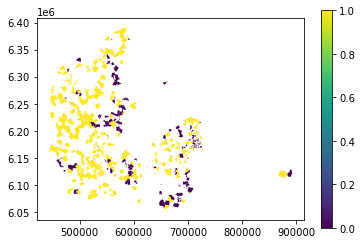

In [186]:
error_gdf.dropna().plot(column='correct_prediction', legend=True)

In [188]:
error_gdf.correct_prediction.sum()/len(error_gdf.dropna())


0.6591928251121076

## Elastic net - crossvalidation:

In [271]:
pipe_el.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'polynomialfeatures', 'standardscaler', 'elasticnet', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'polynomialfeatures__order', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'elasticnet__alpha', 'elasticnet__copy_X', 'elasticnet__fit_intercept', 'elasticnet__l1_ratio', 'elasticnet__max_iter', 'elasticnet__normalize', 'elasticnet__positive', 'elasticnet__precompute', 'elasticnet__random_state', 'elasticnet__selection', 'elasticnet__tol', 'elasticnet__warm_start'])

In [286]:
# compare performance
models = {'LinReg': pipe_lr, 'Lasso': pipe_lasso, 'Lasso CV': pipe_lassoCV,
         'Ridge': pipe_ridge, 'Ridge CV': pipe_ridgeCV,}
for name, model in models.items():
    score = mse(model.predict(X_test),y_test)
    print(name, round(score, 5))

LinReg 0.00401
Lasso 0.0121
Lasso CV 0.00414
Ridge 0.01173
Ridge CV 0.00644


In [276]:
pipe_el = make_pipeline(PolynomialFeatures(include_bias=True),StandardScaler(),ElasticNet())
gs = GridSearchCV(estimator=pipe_el,
                  param_grid = {'elasticnet__alpha':np.logspace(-4,4,10)*2,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)},
                  scoring='neg_mean_squared_error',
                  n_jobs=4,
                  iid=False,
                  cv=10)
models['ElasticNetCV'] = gs.fit(X_dev, y_dev)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('elasticnet', ElasticNet())]),
             iid=False, n_jobs=4,
             param_grid={'elasticnet__alpha': array([2.00000000e-04, 1.54852737e-03, 1.19896850e-02, 9.28317767e-02,
       7.18762733e-01, 5.56511880e+00, 4.30886938e+01, 3.33620107e+02,
       2.58309933e+03, 2.00000000e+04]),
                         'elasticnet__l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             scoring='neg_mean_squared_error')